In [4]:
from pymdp import utils
import numpy as np
from scipy.stats import norm
import math
from pymdp.maths import softmax

import jax.numpy as jnp
import jax.tree_util as jtu
from jax import random as jr, config, jit
from pymdp.jax.agent import Agent as AIFAgent
from functools import partial
from equinox import tree_at

from pymdp.jax.maths import log_stable
import jax
e=0.0000#観測モデルの下駄（定常発火）0.0001
sa1=4#観測モデルの標準偏差（支払い値をサンプリングするガウス分布の標準偏差）
sa2=sa1
sa3=sa1
sa4=sa1
sb1=2.8#状態遷移の標準偏差（減衰ランダムウォークの拡散ノイズの標準偏差）
sb2=sb1
sb3=sb1#4.28
sb4=sb3#sb1
ramda=0.98363#減衰ランダムウォークの減衰パラメータ
#o_control=5#観測（支払い値）のデータ
#u_control=1#選択された行動（スロット）
cgrad=0.5#7.06#選好関数の傾き
#cshape=2#選好関数の形状（対数の底）
alpha=1.0#0.837#行動選択の精度
num_obs = [101, 101, 101, 101] # observation modality dimensions，観測の次元数．観測は各スロットに対して，支払値なし，支払値1,支払値2，...支払値10の11通り．例）obs=[0,0,6,0]のとき，スロット3から支払値6が排出．
num_states = [100, 100, 100, 100, 4] # hidden state factor dimensions，隠れ状態の次元数．1~4因子目：各スロットの平均支払値．5因子目：自分が選択したスロット．
num_controls = [1, 1, 1, 1, 4] # control state factor dimensions，制御状態の次元数＝各隠れ状態に対するBの数．スロット1~4の平均支払値は行動に寄らず状態遷移確率が変わらないので制御状態の次元数1．行動によってどのスロットから支払値を獲得するかが変わる，スロットは4つなので制御状態は4つ
num_states_A = [100,  4]
Ns1=num_states[0]


num_factors = len(num_states)
D = utils.obj_array(num_factors)#初期事前分布の設定
D[0] = np.ones(100)/100#スロット1の平均支払値が1~10の値を等確率で取りうるという事前信念
D[1] = np.ones(100)/100
D[2]= np.ones(100)/100
D[3] = np.ones(100)/100
#D[4] = np.zeros(8)
D[4] = np.array([1/4, 1/4, 1/4 ,1/4])#自分が選んだスロット（行動）に対する信念．初期時刻はランダム．
#D[4][u_control+3]=1

                  
#A_array = utils.random_A_matrix(num_obs, num_states) # create sensory likelihood (A matrix)
A_shapes = [[o_dim] + num_states_A for o_dim in num_obs]
# initialize the A array to all 0's
A_array = utils.obj_array_zeros(A_shapes)
l = np.arange(0,100,1)
for m in range(0,num_states[0],1):
    
    A_array[0][0,m,0]=0 #スロット1を選択したとき（制御状態0），スロット1の「支払値なし」の観測が生成される確率は0
    A_array[0][1:101,m,0]=  norm.pdf(l,m,sa1)+e #平均m（因子1の隠れ状態）標準偏差sa1の正規分布にもとづく確率密度，10次元のベクトル．
    A_array[0][0,m,1]=1#スロット1を選択したとき（制御状態0），スロット2の「支払値なし」の観測が生成される確率は1.
    A_array[0][0,m,2]=1
    A_array[0][0,m,3]=1



for n in range(0,num_states[1],1):

            
    A_array[1][0,n,0]=1
    A_array[1][0,n,1]=0
    A_array[1][1:101,n,1]=norm.pdf(l,n,sa2)+e
    A_array[1][0,n,2]=1
    A_array[1][0,n,3]=1



for o in range(0,num_states[2],1):

        
    A_array[2][0,o,0]=1
    A_array[2][0,o,1]=1
    A_array[2][0,o,2]=0
    A_array[2][1:101,o,2]=norm.pdf(l,o,sa3)+e
    A_array[2][0,o,3]=1



for p in range(0,num_states[3],1):
    
    A_array[3][0,p,0]=1
    A_array[3][0,p,1]=1
    A_array[3][0,p,2]=1
    A_array[3][0,p,3]=0
    A_array[3][1:101,p,3]=norm.pdf(l,p,sa4)+e

A_array = utils.norm_dist_obj_arr(A_array)#列ごとに正規化             

B_shapes = [[s_dim, s_dim, num_controls[f]] for f, s_dim in enumerate(num_states)]
# initialize the B array to uniform distributions as columns
#uniform_B = utils.obj_array_uniform(B_shapes)
#B_array = utils.random_B_matrix(num_states, num_controls) # create transition likelihood (B matrix)
#rng = np.random.default_rng()#+rng.normal(0, sb1))
# initialize the B array to all 0's
B_array = utils.obj_array_zeros(B_shapes)
theta=49 #減衰中心
for st in range(0,num_states[0],1):
    nexts=round(ramda*st+(1-ramda)*theta)#時刻tの平均支払値がstであるときの時刻t+1の平均支払値の期待値．
    if nexts>99:
        nexts=99
    if nexts<0:
        nexts=0
    B_array[0][:,st,0]=norm.pdf(l,nexts,sb1)#平均がnexts，標準偏差がsb1の正規分布の確率密度．次の時点の隠れ状態に対する予測を記述．

for st in range(0,num_states[1],1):
    nexts=round(ramda*st+(1-ramda)*theta)
    if nexts>99:
        nexts=99
    if nexts<0:
        nexts=0
    B_array[1][:,st,0]=norm.pdf(l,nexts,sb2)

for st in range(0,num_states[2],1):
    nexts=round(ramda*st+(1-ramda)*theta)
    if nexts>99:
        nexts=99
    if nexts<0:
        nexts=0
    B_array[2][:,st,0]=norm.pdf(l,nexts,sb3)

for st in range(0,num_states[3],1):
    nexts=round(ramda*st+(1-ramda)*theta)
    if nexts>99:
        nexts=99
    if nexts<0:
        nexts=0
    B_array[3][:,st,0]=norm.pdf(l,nexts,sb4)

for controls in range(0,num_states[4],1):
    B_array[4][controls,:,controls]=[1,1,1,1]#選択された制御状態に確率1で遷移する．
B_array = utils.norm_dist_obj_arr(B_array)#列ごとに正規化  


C_shapes = [[o_dim] for o_dim in num_obs]
C_vector = utils.obj_array_zeros(C_shapes)
C_vector[0][0]=0
for m in range(1,num_obs[0],1):
    C_vector[0][m] = cgrad* math.log(m)#スロット1の支払値に対する選好．対数関数で定義．
C_vector[1][0]=0
for m in range(1,num_obs[1],1):
    C_vector[1][m] = cgrad* math.log(m)
C_vector[2][0]=0
for m in range(1,num_obs[2],1):
    C_vector[2][m] = cgrad* math.log(m)
C_vector[3][0]=0
for m in range(1,num_obs[3],1):
    C_vector[3][m] = cgrad* math.log(m)
C_vector[0]=np.log(softmax(C_vector[0]))#softmaxで確率分布化⇒pymdpの仕様でlnp(o|C)の形式でAgentに入力する．
C_vector[1]=np.log(softmax(C_vector[1]))
C_vector[2]=np.log(softmax(C_vector[2]))
C_vector[3]=np.log(softmax(C_vector[3]))

#C_vector = utils.obj_array_uniform(num_obs) # uniform preferences

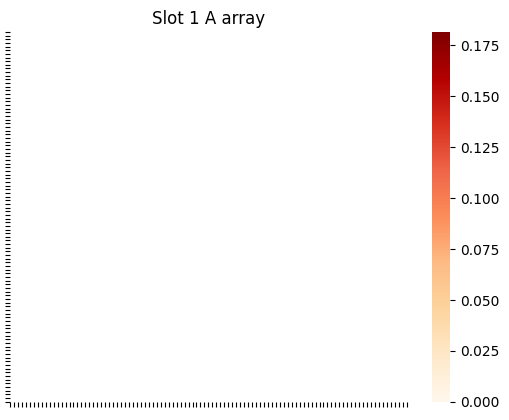

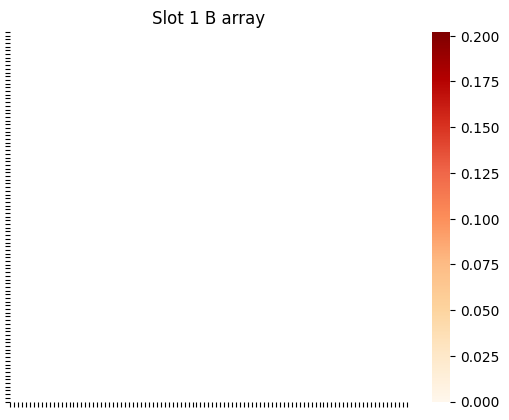

In [5]:
from pymdp.utils import plot_beliefs, plot_likelihood
#print(A_array[0][:,:,0,0,0,0])
#plot_likelihood(A_array[0][:,:,0],'Slot 1 A array')
#plot_likelihood(B_array[0][:,:,0],'Slot 1 B array')

In [7]:
class FourArmedBandit(object):#生成プロセスの定義

  def __init__(self, D_env):#初期化関数．各スロットの初期値をランダムに決定．

    self.s_slot1 = utils.sample(D_env[0]) # randomly sample which bandit arm is better (Left or Right)
    self.s_slot2 = utils.sample(D_env[1])
    self.s_slot3 = utils.sample(D_env[2])
    self.s_slot4 = utils.sample(D_env[3])
    self.s_action = utils.sample(D_env[4])

  def step(self, action_idx):#観測の生成関数．#(self, action_idx, o_control):
    obs_slot1=0 #0:no cue
    obs_slot2=0
    obs_slot3=0
    obs_slot4=0
    #controlledobs_slot1=0
    #controlledobs_slot2=0
    #controlledobs_slot3=0
    #controlledobs_slot4=0
    
    rng = np.random.default_rng()
    self.s_slot1=round(ramda*self.s_slot1+(1-ramda)*theta+rng.normal(0, sb1))#真の平均支払い値の遷移
    if self.s_slot1>99:#平均支払い値を1~10に収める
        self.s_slot1=99
    if self.s_slot1<0:
        self.s_slot1=0
    self.s_slot2=round(ramda*self.s_slot2+(1-ramda)*theta+rng.normal(0, sb2))#真の平均支払い値の遷移
    if self.s_slot2>99:#平均支払い値を1~10に収める
        self.s_slot2=99
    if self.s_slot2<0:
        self.s_slot2=0
    self.s_slot3=round(ramda*self.s_slot3+(1-ramda)*theta+rng.normal(0, sb3))#真の平均支払い値の遷移
    if self.s_slot3>99:#平均支払い値を1~10に収める
        self.s_slot3=99
    if self.s_slot3<0:
        self.s_slot3=0
    self.s_slot4=round(ramda*self.s_slot4+(1-ramda)*theta+rng.normal(0, sb4))#真の平均支払い値の遷移
    if self.s_slot4>99:#平均支払い値を1~10に収める
        self.s_slot4=99
    if self.s_slot4<0:
        self.s_slot4=0
    
    if action_idx[0][4] == 0:#制御状態が0のとき（スロット1を選択したとき）:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot1,sa1)
      A_env = A_env/np.sum(A_env)
      obs_slot1 = utils.sample(A_env)
    
    elif action_idx[0][4] == 1:#1:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot2,sa2)
      A_env = A_env/np.sum(A_env)
      obs_slot2 = utils.sample(A_env)
    
    elif action_idx[0][4] == 2:#2:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot3,sa3)
      A_env = A_env/np.sum(A_env)
      obs_slot3 = utils.sample(A_env)
    
    elif action_idx[0][4] == 3:#3:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot4,sa4)
      A_env = A_env/np.sum(A_env)
      obs_slot4 = utils.sample(A_env)

    #elif action_idx == 4:
      
      #obs_slot1 = o_control
    
    #elif action_idx == 5:
      
      #obs_slot2 = o_control
    
    #elif action_idx == 6:
      
      #obs_slot3 = o_control
    #elif action_idx == 7:
      
      #obs_slot4 = o_control
    obs = [obs_slot1, obs_slot2, obs_slot3, obs_slot4]
    obs_jax = jtu.tree_map(lambda x: jnp.expand_dims(x, -1).astype(jnp.int32), obs)#jax用にbatch次元？を追加
    #return [[obs],[self] ]
    return obs_jax
  
  def reset(self):#時刻1の観測のサンプリング#(self ,o_control):
    
    obs_slot1=0 #0:no cue
    obs_slot2=0
    obs_slot3=0
    obs_slot4=0
    if self.s_action == 0:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot1,sa1)
      A_env = A_env/np.sum(A_env)
      obs_slot1 = utils.sample(A_env)
    
    elif self.s_action == 1:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot2,sa2)
      A_env = A_env/np.sum(A_env)
      obs_slot2 = utils.sample(A_env)
    
    elif self.s_action == 2:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot3,sa3)
      A_env = A_env/np.sum(A_env)
      obs_slot3 = utils.sample(A_env)
    
    elif self.s_action == 3:
      
      A_env=np.zeros((101))
      A_env[0]=0
      A_env[1:101]=norm.pdf(l,self.s_slot4,sa4)
      A_env = A_env/np.sum(A_env)
      obs_slot4 = utils.sample(A_env)

    #elif self.s_action == 4:
      
      #obs_slot1 = o_control
    
    #elif self.s_action == 5:
      
      #obs_slot2 = o_control
    
    #elif self.s_action == 6:
      
      #obs_slot3 = o_control
    #elif self.s_action == 7:
    
      #obs_slot4 = o_control
    obs = [obs_slot1, obs_slot2, obs_slot3, obs_slot4]
    #print(obs)
    obs_jax = jtu.tree_map(lambda x: jnp.expand_dims(x, -1).astype(jnp.int32), obs)#jax用にbatch次元？を追加
    actions_t = jnp.array([[0,0,0,0,self.s_action]])
    #return [[obs],[self] ]
    #print(obs_jax)
    return obs_jax, actions_t

In [8]:
#def run_active_inference_loop(my_agent, my_env, T = 10):
batch_size = 1 # number of agents

#jax

A_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(A_array))#jax用にbatch次元を追加．
B_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(B_array))
C_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(C_vector))
D_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(D))

batch_keys = jr.split(jr.PRNGKey(0), batch_size)
#batch_keys = jr.split(batch_keys[0], batch_size)
#batch_keys = jr.split(batch_keys[0], batch_size)  

A_dependencies=[[0, 4], [1, 4], [2,  4], [3, 4]]#各モダリティがどの状態因子に対応するかを記述する
B_dependencies=None
#AIFエージェントの宣言
agents = AIFAgent(A=A_jax, B=B_jax, C=C_jax, D=D_jax, E=None, pA=None, pB=None,  inference_algo="mmp", learn_A=False, learn_B=False, learn_C=False, learn_D=False, learn_E=False, A_dependencies=A_dependencies, B_dependencies=B_dependencies, gamma=1., alpha=1., action_selection="stochastic", policy_len=1, use_utility=True, use_states_info_gain=True, use_param_info_gain=False, use_inductive=False, onehot_obs=False, sampling_mode="full",num_iter=8)
#AIFの処理を行う関数．「@partial～」をコメントアウトするとupdate_agent内でもprint文で出力を確認可能．
@partial(jit, static_argnames=['batch_size','num_history'])
def update_agent(agents, outcomes, actions, infer_args, batch_keys, batch_size=1, num_history=1000):

    #認識・vfeの計算
    beliefs,err, vfe,kld2, bs, un = agents.infer_states_vfe(outcomes, infer_args[0], past_actions=actions, qs_hist=infer_args[1])
    #kld = agents.calc_KLD_past_currentqs(empirical_prior, infer_args[1], beliefs)
    #行動選択確率（q_pi）の計算，efeの計算
    q_pi, neg_efe, pbs, pkld, pfe, oRisk, pbs_pA, pbs_pB = agents.infer_policies_efe(beliefs)##
    Hqo=pfe-pkld#q(o|π)のEntropy
    negefe_tmp=neg_efe[0]-pbs_pA[0]-pbs_pB[0]#novelty項を除いたEFE
    #print(f'    efe at time {t}: {neg_efe[0]}')
    #print(pbs)
    #print(neg_efe)

    #行動のサンプリング
    #batch_keys = jr.split(jr.PRNGKey(0), batch_size)
    #actions_t, policy_idx = agents.sample_action_policy_idx(q_pi, rng_key=batch_keys)#q_pi_0
    batch_keys = jr.split(batch_keys[0], batch_size)#乱数のシャッフル
    actions_t = agents.sample_action(q_pi, rng_key=batch_keys)
    #print(policy_idx)
    #past_beliefs=next_past_beliefs

    #行動・観測履歴・信念（認識）の配列の更新
    if actions is not None:
        actions = jnp.concatenate([actions, jnp.expand_dims(actions_t, -2)], -2)##次の推論でsampleactionしたものが使われる？
    else:
        actions = jnp.expand_dims(actions_t, -2)
    outcomes = jtu.tree_map( lambda x: x[:, -num_history:], outcomes)
    #print(f'    outcomes at time {T}: {outcomes}')
    beliefs = jtu.tree_map( lambda x: x[:, -num_history:], beliefs)
    #print(f'    beliefs at time {T}: {beliefs}')
    actions = jtu.tree_map( lambda x: x[:,-num_history:], actions)
    #print(f'    actions at time {T}: {actions}')
    ###

    # Dの学習
    #agents = tree_at(lambda x: x.D, agents, jtu.tree_map(lambda x: x[:, 0], beliefs)) 

    #次のタイムステップのための事前分布（=MMPでは上の処理で作成したbeliefs）の作成
    infer_args = agents.update_empirical_prior(actions_t, beliefs)
    #empirical_prior = beliefs
    #print(f'    infer_args at time {T}: {infer_args}')


    # Learning #
    ##学習用の観測・認識セットの準備
    beliefs_last = jtu.tree_map( lambda x: x[:, -1:], beliefs) # take the last belief
    #print(f'    beliefs_last at time {T}: {beliefs_last}')
    outcomes_last = jtu.tree_map( lambda x: x[:, -1:], outcomes) # take the last outcome
    #print(f'    outcomes_last at time {T}: {outcomes_last}')
    applied_actions_last = jtu.tree_map( lambda x: x[:,-2:-1], actions) # take the last applied action
    #print(f'    applied_actions_last at time {T}: {applied_actions_last}')
    beliefs_last_pair = jtu.tree_map( lambda x: x[:, -2:], beliefs) # take the last two beliefs
    ####

    ##A,Bの更新（学習）
    ##agents = agents.infer_parameters(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair)

    # How to put learning rate
    # lr_pA = 1.0 + jnp.zeros(batch_size)
    # lr_pB = 1.0 + jnp.zeros(batch_size)
    # agents = agents.infer_parameters(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair, lr_pA=lr_pA, lr_pB=lr_pB)
    # learning using moving window (you have to put window size as num_history.)
    # lr_pA = 1.0/num_history + jnp.zeros(batch_size)
    # lr_pB = 1.0/num_history + jnp.zeros(batch_size)
    # applied_actions = jtu.tree_map( lambda x: x[:,:-1], actions)
    # agents = agents.infer_parameters(beliefs, outcomes, applied_actions, beliefs_B=beliefs, lr_pA=lr_pA, lr_pB=lr_pB) 
    #agents = tree_at(lambda x: x.onehot_obs, agents, True)
    #agents = tree_at(lambda x: x.onehot_obs, agents, False)

    vfe =vfe[0][0]
    vfe=[vfe[-1]]#現在時点の隠れ状態に対するVFEを出力
    bs =bs[0][0]
    bs=[bs[-1]]#現在時点の隠れ状態に対するVFEを出力
    un =un[0][0]
    un=[un[-1]]#現在時点の隠れ状態に対するVFEを出力
    #kld=kld[0]#kld1のとき
    ##kld=kld2[0][0]
    #kld=[kld[-1]]
    return agents, outcomes, actions, infer_args, batch_keys, neg_efe, vfe,  bs, un, pbs, pbs_pA, pbs_pB,  Hqo, pkld, pfe, oRisk


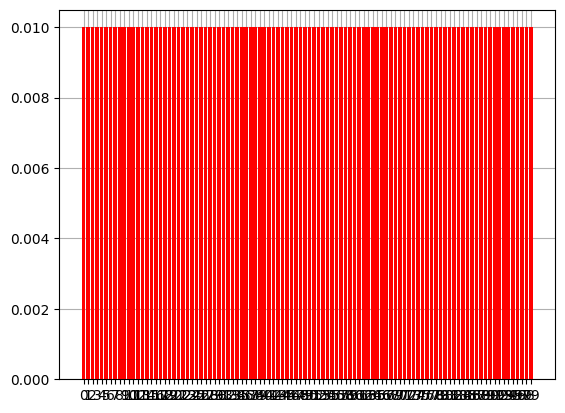

selected action [[0 0 0 0 2]]


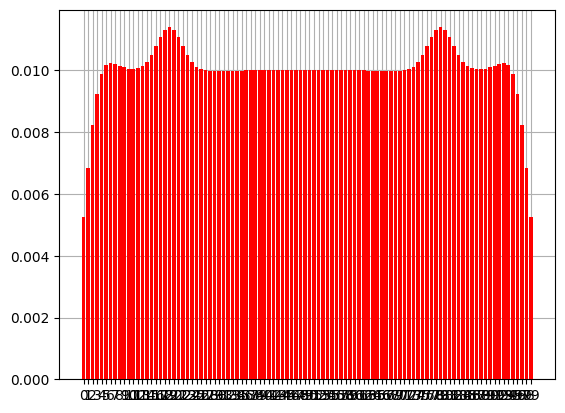

selected action [[0 0 0 0 2]]


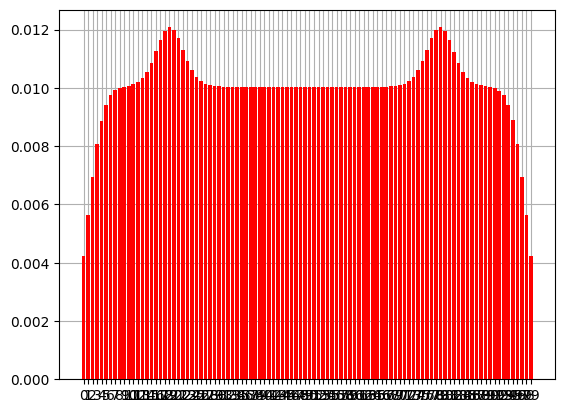

selected action [[0 0 0 0 3]]


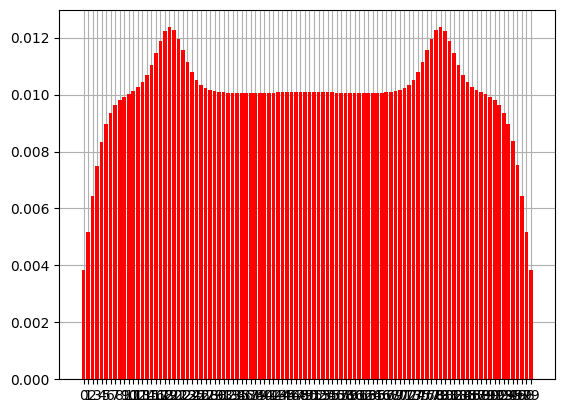

selected action [[0 0 0 0 2]]


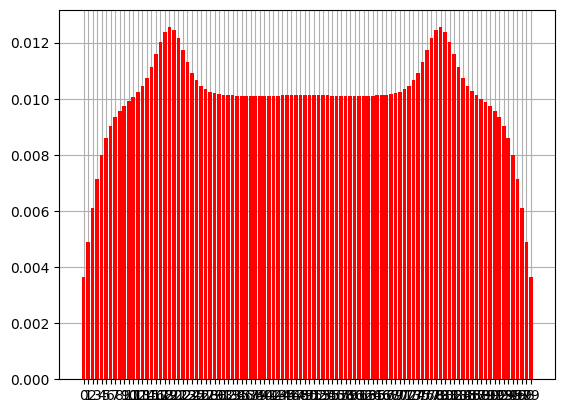

selected action [[0 0 0 0 0]]


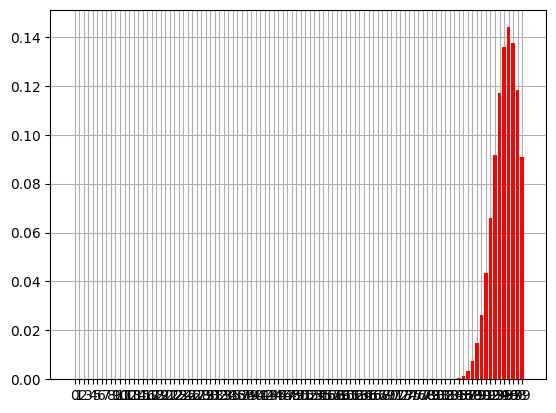

selected action [[0 0 0 0 2]]


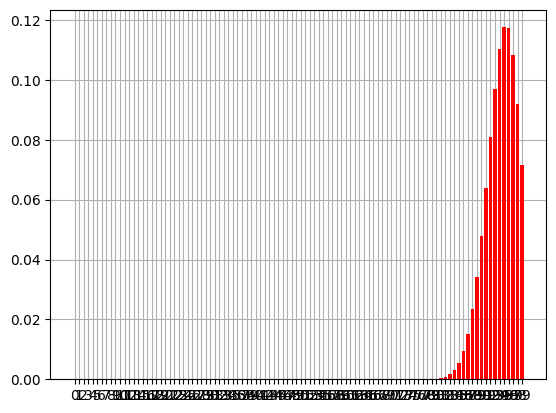

selected action [[0 0 0 0 1]]


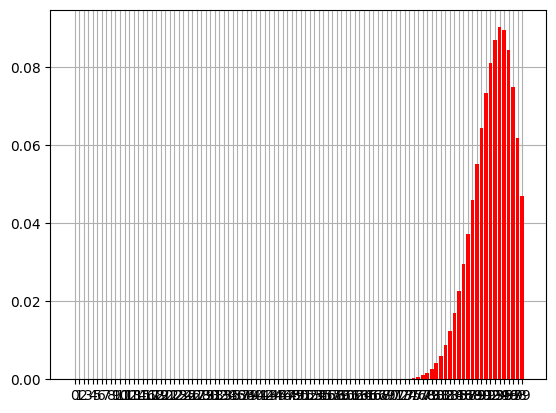

selected action [[0 0 0 0 3]]


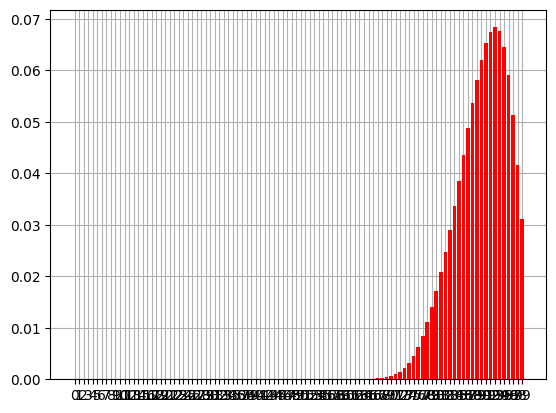

selected action [[0 0 0 0 2]]


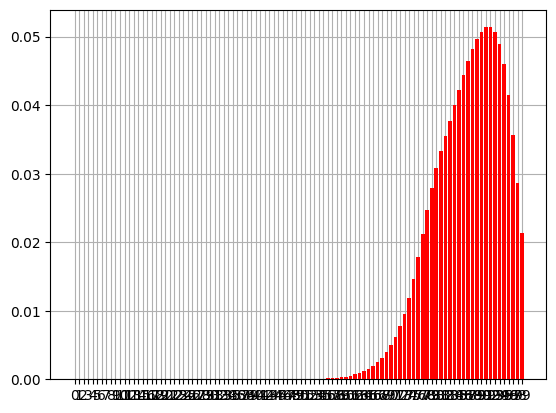

In [9]:
T=10
EFE=[]
VFE=[]
PBS=[]
PKLD=[]
PFE=[]
Risk=[]
Ambiguity=[]
Pragmaticvalue=[]
KLD=[]
BS=[]

D_env=D
my_env=FourArmedBandit(D_env)
obs, first_action = my_env.reset()#初期時刻の観測と行動のサンプリング
#print(obs)
obs_record=[obs]
#chosen_policies=[first_action]
#print(first_action)
#policies=np.array([np.array([[0,0,0,0,0]]), np.array([[0,0,0,0,1]]), np.array([[0,0,0,0,2]]), np.array([[0,0,0,0,3]])])#np.array([np.array([[0]]),t=2:np.array([np.array([[1]]),..)
#print(policies)

#agents = AIFAgent(A=A_jax, B=B_jax, C=C_jax, D=D_jax, E=None, pA=None, pB=None, learn_A=False, learn_B=False, learn_C=False, learn_D=False, learn_E=False, A_dependencies=None, B_dependencies=None, gamma=1., alpha=1., inference_algo="fpi", action_selection="stochastic", policy_len=1, use_utility=True, use_states_info_gain=True, use_param_info_gain=False, use_inductive=False, onehot_obs=False, sampling_mode="full")
beliefs=None
#print(agents.A_dependencies)
#print(agents.B_dependencies)
#print(agents.policies)
for t in range(T):
  if t == 0:
      
      actions_t = None ##first_action#None # no action available at the first time step
      #print(actions_t)
      actions = None # no action available at the first time step
      prob_pi = None
      #prob_pi = jnp.expand_dims(jnp.array([[0,0,0,0,self.s_action]]), -2) D_jax[4]
      infer_args = (agents.D, None,)#(qs_pi, qs_hist)
      outcome_t  = None
      outcomes = None
      #empirical_prior =agents.D ##KLD計算用の事前分布．
  else:
      print("selected action",actions_t)
      #empirical_prior = agents.compute_expected_state(actions_t, empirical_prior)#KLD計算用の事前分布．事前分布をB*qsとする場合

  batch_keys = jr.split(batch_keys[0], batch_size)
  outcome_t  = jtu.tree_map(lambda x: jnp.expand_dims(x, -1), obs)
  #print(f'    outcome_t at time {T}: {outcome_t}')
  
  if outcomes is None:
      outcomes = outcome_t
  else:
      outcomes = jtu.tree_map(lambda prev_o, new_o: jnp.concatenate([prev_o, new_o], -1), outcomes, outcome_t) 

  num_history=5 #推論する時間幅．5であれば現在から過去5タイムステップ分の隠れ状態を推論．
  agents, outcomes, actions, infer_args, batch_keys, neg_efe, vfe,  bs, un, pbs,  pbs_pA, pbs_pB,  Hqo, pkld, pfe, oRisk = update_agent(
      agents, 
      outcomes, 
      actions, 
      infer_args, 
      batch_keys,
      batch_size=batch_size,
      num_history=num_history
  )
  #print(infer_args[1][0][0])
  plot_beliefs(infer_args[1][0][-1][-1])
  #plot_beliefs(empirical_prior[0][-1][-1])
  """ if T < num_history:
    qs_1 = infer_args[1][0][0, 0] # snapshot of s1 for D-learning """
  actions_t = actions[:,-1]
  #print(actions_t)
  #print(actions_t[0][4])
  obs = my_env.step(actions_t)#次の時刻の観測をサンプリング
  #prev_obs=[obs]#次の時刻の観測を指定．
  obs_record.append(obs)
  #chosen_policy_idx=int(actions_t[4])    

  #情報量記録
  """ efe = np.array(-neg_efe[0])
  min_index = np.argmin(efe)  # efeの最小値のインデックスを取得
  efe_min = efe[min_index] """
  #print(f'    efe_min at time {T}: {efe_min}')
  #efes.append(efe_min)
  PBS.append(pbs)#=np.append(PBS,pbs)  
  PKLD.append(pkld)
  PFE.append(pfe)
  Risk.append(oRisk)  
  ambi=pfe-pbs-pkld
  Ambiguity.append(ambi)
  Pv=-oRisk+Hqo
  Pragmaticvalue.append(Pv)
  #chosen_policies.append(chosen_policy_idx)
  #VFE.append(vfe)
  EFE.append(-1*neg_efe)


#可視化のためのデータ整形
PBS=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), PBS) 
PBS=np.array(PBS) 
PBS=PBS.T
PBS=PBS.tolist()
PKLD=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), PKLD) 
PKLD=np.array(PKLD) 
PKLD=PKLD.T
PKLD=PKLD.tolist()
PFE=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), PFE) 
PFE=np.array(PFE) 
PFE=PFE.T
PFE=PFE.tolist()
Ambiguity=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), Ambiguity) 
Ambiguity=np.array(Ambiguity) 
Ambiguity=Ambiguity.T
Ambiguity=Ambiguity.tolist()
Risk=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), Risk) 
Risk=np.array(Risk) 
Risk=Risk.T
Risk=Risk.tolist()
Pragmaticvalue=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), Pragmaticvalue) 
Pragmaticvalue=np.array(Pragmaticvalue) 
Pragmaticvalue=Pragmaticvalue.T
Pragmaticvalue=Pragmaticvalue.tolist()

EFE=jtu.tree_map(lambda x: jnp.reshape(x, (4,)), EFE) 
EFE=np.array(EFE)
EFE=EFE.T
EFE=EFE.tolist()

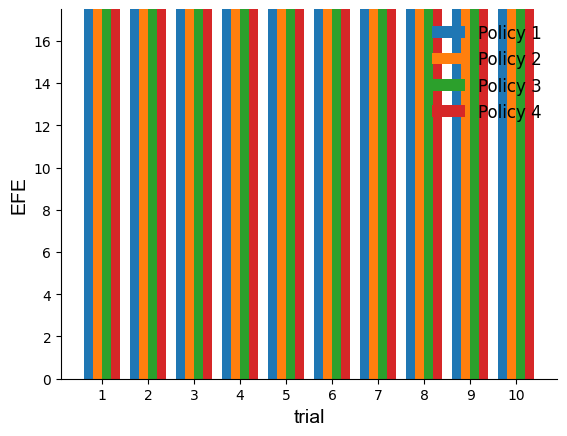

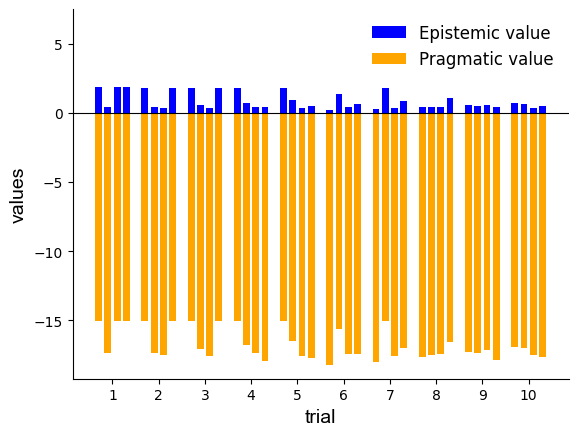

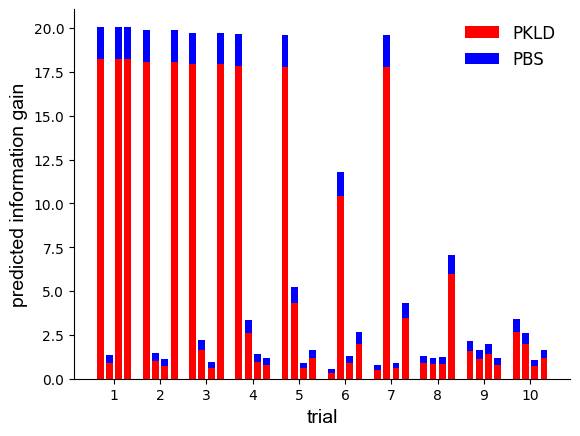

In [10]:
##プロット
%matplotlib inline
import matplotlib
#matplotlib.use('Qt5Agg')  # Qt5Aggをバックエンドとして使用
import matplotlib.pyplot as plt

if __name__ == "__main__": 
  labels=['1','2','3','4','5','6','7','8','9','10']  # set the dates as labels
  x0 = np.arange(len(labels))  # create an array of values for the ticks that can perform arithmetic with width (w)

# create the data groups with a dict comprehension and groupby
  # マージンを設定
  margin = 0.2  #0 <margin< 1
  total_width = 1 - margin
#EFEの可視化
  fig, ax = plt.subplots()
  # 棒グラフをプロット
  """ for i, h in enumerate(EFE):
    pos = x0 - total_width *( 1- (2*i+1)/len(EFE) )/2
    plt.bar(pos, h, width = total_width/len(EFE)) """
  num_policies = 4
  for i in range(num_policies):
     pos = x0 - total_width *( 1- (2*i+1)/len(EFE) )/2
     ax.bar(pos, EFE[i], width=total_width/len(EFE), label=f'Policy {i+1}')
  # ラベルの設定
  plt.xticks(x0, labels)
  plt.xlabel("trial", fontname="Arial", fontsize=14)
  plt.ylabel("EFE", fontname="Arial", fontsize=14)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.legend(fontsize=12, frameon=False)
  plt.ylim(top=17.5) 
  plt.show
# build the plots
#subs = df.subsidiary.unique()
  stacks = 4  # how many stacks in each group for a tick location
# set the width
  w = 0.15

# this needs to be adjusted based on the number of stacks; each location needs to be split into the proper number of locations
  x1 = [x0 - w*2, x0 - 2*w/3, x0 + 2*w/3, x0 + w*2]
  data=[]
  for p in range(0,agents.policies.ndim+1,1):

    data.append(PBS[p])#ambiguity. (EFE=Ambiguity+Risk)
    data.append(Pragmaticvalue[p])

  data=np.array(data)#data.value.to_numpy() 
  #print(data)
  fig, ax = plt.subplots()
  colors = ['blue', 'orange' ]  # 各要素の色を指定
  legends = ['Epistemic value','Pragmatic value']
  for i, x in enumerate(x1):
    if i==0:
      ax.bar(x, PBS[i], width=w, color=colors[0],label=legends[0])
      ax.bar(x, Pragmaticvalue[i], width=w, color=colors[1], label=legends[1])
    else:
      ax.bar(x, PBS[i], width=w, color=colors[0])
      ax.bar(x, Pragmaticvalue[i], width=w, color=colors[1])
  ax.axhline(0, color='black', linewidth=0.8)  # 0ラインを追加
  ax.set_xticks(x0)
  ax.set_xticklabels(labels)

  plt.ylim(top=7.5) 
  plt.xticks(x0, labels)
  plt.xlabel("trial", fontname="Arial", fontsize=14)
  plt.ylabel("values", fontname="Arial", fontsize=14)
  plt.legend(fontsize=12, loc="upper right", frameon=False)
  #plt.legend(legends, fontsize=12,loc="upper right", frameon=False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.show()
  #Risk,Ambiguityの可視化，pBS,pKLDの可視化
  """ data=[]
  for p in range(0,agents.policies.ndim+1,1):

    data.append(Ambiguity[p])#ambiguity. (EFE=Ambiguity+Risk)
    data.append(Risk[p])

  data=np.array(data)#data.value.to_numpy() 
  #print(data)
  fig, ax = plt.subplots()
  colors = ['green', 'black' ]  # 各要素の色を指定
  legends = [ 'Ambiguity','Risk']
  for x, j in zip(x1,list(range(4))):
      bottom = 0
      for i, color, legend in zip(list(range(2)), colors, legends):#Ambiguity,Risk
          height = data[i+j*2] #.value.to_numpy()
          ax.bar(x=x, height=height, width=w, bottom=bottom, color=color, label=legend)
          bottom += height


  ax.set_xticks(x0)
  _ = ax.set_xticklabels(labels)
  plt.xticks(x0, labels)
  plt.xlabel("trial", fontname="Arial", fontsize=14)
  plt.ylabel("EFE", fontname="Arial", fontsize=14)
  plt.legend(legends, fontsize=12,loc="upper right", frameon=False)"""
  ##pBS,pKLDの可視化
  data=[]
  for p in range(0,agents.policies.ndim+1,1):
    data.append(PKLD[p])#data.append(PKLD[p])
    data.append(PBS[p])

  data=np.array(data)#data.value.to_numpy() 
  #print(data) 
  fig, ax = plt.subplots()
  colors = ['red','blue' ]  # 各要素の色を指定
  legends = ['PKLD', 'PBS']
  for x, j in zip(x1,list(range(4))):
      bottom = 0
      for i, color, legend in zip(list(range(2)), colors, legends):#PKLD,PBS,PFE,Risk
          height = data[i+j*2] #.value.to_numpy()
          ax.bar(x=x, height=height, width=w, bottom=bottom, color=color, label=legend)
          bottom += height
          
  #ax.invert_yaxis()
  ax.set_xticks(x0)
  _ = ax.set_xticklabels(labels)
  plt.xlabel("trial", fontname="Arial", fontsize=14)
  plt.ylabel("predicted information gain", fontname="Arial", fontsize=14)
  #plt.legend(fontsize=12, frameon=False)
  # 指定した凡例のみを表示
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.legend(legends, fontsize=12, loc="upper right",frameon=False)
  plt.show()

  #print(outcomes)
  #print(actions)
  #print(prob_pi)
  #print(beliefs)
  


In [61]:
print(obs_record)

[[Array([7], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32)], [Array([0], dtype=int32), Array([0], dtype=int32), Array([1], dtype=int32), Array([0], dtype=int32)], [Array([0], dtype=int32), Array([6], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32)], [Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Array([10], dtype=int32)], [Array([0], dtype=int32), Array([0], dtype=int32), Array([2], dtype=int32), Array([0], dtype=int32)], [Array([9], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32)], [Array([0], dtype=int32), Array([0], dtype=int32), Array([1], dtype=int32), Array([0], dtype=int32)], [Array([10], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32)], [Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Array([10], dtype=int32)], [Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Ar